# Special case: evaporation of water



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas, hypothetical_concentration, metabolised_amount
from pseudobatch.datasets import load_evaporation_fedbatch

In [2]:
fedbatch_df = load_evaporation_fedbatch()

<Axes: xlabel='timestamp'>

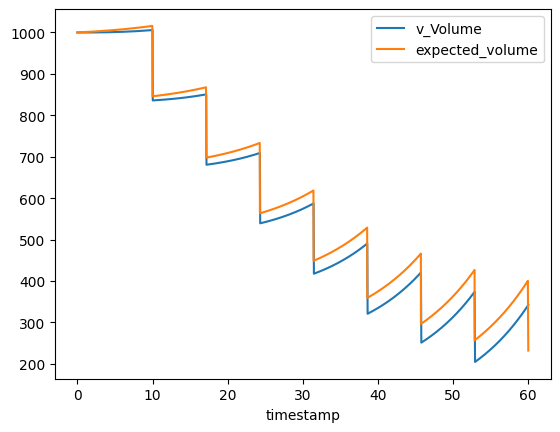

In [26]:
initial_volume = fedbatch_df['v_Volume'].iloc[0]
fedbatch_df['expected_volume'] = initial_volume + fedbatch_df['v_Feed_accum'] - fedbatch_df['sample_volume'].cumsum()
# accum_evaporation = expected_volume - fedbatch_df['v_Volume']
# accum_evaporation
fedbatch_df.plot(
    x='timestamp',
    y=['v_Volume', 'expected_volume']
)

Now, we can transform the hypothetical CO2 concentration and the biomass concentration measurements.

In [32]:
substrate_in_feed = fedbatch_df['s_f'].iloc[0]
fedbatch_df[['pseudo_Biomass', 'pseudo_Glucose']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,substrate_in_feed],
    sample_volume_colname='sample_volume'
)


In [35]:
mu0_hat, intercept = np.polyfit(fedbatch_df['timestamp'], fedbatch_df['pseudo_Biomass'].transform(np.log), 1)
print(f"mu0_hat = {round(mu0_hat, 5)}")
print(f"true mu0 = {fedbatch_df['mu0'].iloc[-1]}")

mu0_hat = 0.1
true mu0 = 0.1


In [33]:
Yxs_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_Glucose'], 1)
print(f"Yxs_hat = {Yxs_hat}")
print(f"true Yxs = {fedbatch_df['Yxs'].iloc[-1]}")

Yxs_hat = -1.8500000000000008
true Yxs = 1.85


## Consumed gaseous species, Oxygen
The amount of metabolised $O_2$ has to be calculated from the mass balance. When the oxygen enters the bioreactor some will go straight through and into the off-gas analyzer, and some will be solubilized in the aqueous phase. From the aqueous phase the $O_2$ can either be metabolised or removed through sampling (or evaporate again). Thus, we need to solve the mass balance to find the amount of metabolised $O_2$.

$$
\int_0^t Metabolism=M_{species}(t)-\int_0^t In_{gas}-\int_0^t In_{liquid}+\int_0^t Out_{gas}+\int_0^t Sampled
$$

Some of these terms are obtained from measurements and some can be estimated, e.g. the oxygen content in the liquid feed medium is rarely measured, but is likely insignificant. In this example, we will assume that $\int_0^t In_{liquid}=0$ for all $t$.

You can calculate the metabolized amount of $O_2$ on your own, but it does require special care to use the correct volume and mass' regarding before or after sampling. To ease the processes we have made a function which calculates the metabolized amount for you, `metabolised_amount()`.

At the sampling time points this dataset contains the values just before the sample was taken. However, the `metabolised_amount()` function requires the values from just after the sample withdrawal. In the following we calculate the $O_2$ mass after sample withdrawal.

In [7]:
fedbatch_df['m_O2_after_sample'] = fedbatch_df['m_O2'] - fedbatch_df['c_O2'] * fedbatch_df['sample_volume']

Here, we will use the `metabolised_amount()` function to calculate the mass of consumed $O_2$.

In [8]:
fedbatch_df['m_O2_consumed'] = metabolised_amount(
    off_gas_amount=fedbatch_df['m_O2_gas'].to_numpy(),
    dissolved_amount_after_sampling=fedbatch_df['m_O2_after_sample'].to_numpy(),
    inlet_gas_amount=fedbatch_df['m_O2_in'].to_numpy(),
    sampled_amount=(fedbatch_df['c_O2'] * fedbatch_df['sample_volume']).cumsum().to_numpy(),
    inlet_liquid_amount=np.zeros_like(fedbatch_df['m_O2_in'].to_numpy()),
)

Now, that we have calculated the metabolised amount of $O_2$ we can calculate the hypothetical concentration and run the pseudo batch transformation on the hypothetical concentration data.

In [9]:
fedbatch_df['hypothetical_c_O2'] = hypothetical_concentration(
    metabolised_amount=fedbatch_df['m_O2_consumed'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy(),
)

fedbatch_df['pseudo_O2'] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=['hypothetical_c_O2'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0],
    sample_volume_colname='sample_volume',
)

We are now ready to estimate the oxygen yield coefficient using a linear model.

In [10]:
Yxo2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_O2'], 1)
print(f"Yxo2_hat = {Yxo2_hat}")
print(f"true Yxo2 = {fedbatch_df['Yxo2'].iloc[-1]}")

Yxo2_hat = -0.010000000000000162
true Yxo2 = 0.01


We see that the estimated oxygen yield coefficient match the one used for simulating the data show the the method works.

## Volatile product
Finally, we simulated a generic volatile product which is produced in the liquid and then evaporates through first order kinetics. We will assume that we have measurements both of the evaporating amount and the liquid concentration of the product. For the mass balance we will assume that both $\int_0^t In_{gas}=0$ and $\int_0^t In_{liquid}=0$.

Let's first inspect the raw simulated data.

<Axes: xlabel='timestamp'>

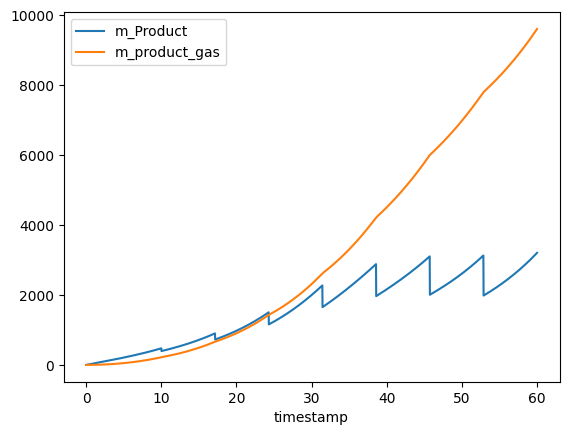

In [11]:
fedbatch_df.plot(
    x='timestamp',
    y=['m_Product', 'm_product_gas']
)

Some of the dissolved product (m_Product) is removed when the bioreactor is sampled, while the product that has evaporated is not removed through sampling. We need to calculate the total production of the product, i.e. combining the two curves above. We can use the `metabolised_amount()` to calculated the total production.

In [12]:
# again first we need to calculate the mass of product after sampling
# to obey the requirements of the metabolised_amount function
fedbatch_df['m_Product_after_sample'] = fedbatch_df['m_Product'].to_numpy() - (fedbatch_df['c_Product'] * fedbatch_df['sample_volume']).to_numpy()

fedbatch_df['m_Product_produced'] = metabolised_amount(
    off_gas_amount=fedbatch_df['m_product_gas'].to_numpy(),
    dissolved_amount_after_sampling=fedbatch_df['m_Product_after_sample'].to_numpy(),
    inlet_gas_amount=np.zeros_like(fedbatch_df['m_Product']),
    sampled_amount=(fedbatch_df['c_Product'] * fedbatch_df['sample_volume']).cumsum().to_numpy(),
)
fedbatch_df['hypothetical_c_Product'] = hypothetical_concentration(
    metabolised_amount=fedbatch_df['m_Product_produced'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy()
)

Now that we have the hypothetical concentration we can perform pseudobatch transformation on the data.

In [13]:
fedbatch_df['pseudo_Product'] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames='hypothetical_c_Product',
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0],
    sample_volume_colname='sample_volume'
)

Finally, we can estimate the product yield coefficient using a linear model.

In [14]:
Yxp_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_Product'], 1)
print(f"Yxp_hat = {Yxp_hat}")
print(f"true Yxp = {fedbatch_df['Yxp'].iloc[-1]}")

Yxp_hat = 0.8215102466751055
true Yxp = 0.8215102466751038


Again, we show that the estimated yield coefficient matches the coefficient that was used for the simulation.

Through out this tutorial we have shown that pseudobatch transformation is capable of handling measurements of gaseous compounds. And how to use the two helper functions `hypethetical_concentration` and `metabolised_amount` to prepare the measurements for pseudo batch transformation.